# Module 1: Optimization Problems & Karush-Kuhn-Tucker (KKT) Conditions


In this module we investigate **optimization basics** (linear and nonlinear programs), notions of **convex functions**, **convex sets**, and **Karush-Kuhn-Tucker optimality conditions**.

We will investigate these concepts through the following examples:
1)  Transportation Problem (LP)

2)  Portfolio Optimization (NLP)

3)  Convexity Analysis

#### Import code packages

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pandas as pd
from pprint import pprint
import numpy as np
import networkx as nx

# Exercise 1.1: Transportation Problem

#### Problem Description

A company operates 3 refineries and must supply diesel to 4 cities. Each refinery has a limited production capacity, and each city has a minimum demand requirement. The company wants to minimize the total cost of distributing diesel while meeting all constraints.

##### Problem Data:
- **Supply**: 3 refineries
- **Demand**: 4 cities
- **Objective**: Minimize total distribution cost





### Task 1: Implement transportation model in Pyomo

#### Explicit mathematical formulation:

**Decision Variables:**
- $x_{ij}$ = amount of diesel distributed from refinery $i$ to city $j$

**Objective Function:**
$$\min Z = 8x_{11} + 6x_{12} + 10x_{13} + 9x_{14} + 9x_{21} + 12x_{22} + 13x_{23} + 7x_{24} + 14x_{31} + 9x_{32} + 16x_{33} + 5x_{34}$$

**Subject to:**

*Supply Constraints:*
- $x_{11} + x_{12} + x_{13} + x_{14} \leq 35$ (Refinery 1 capacity)
- $x_{21} + x_{22} + x_{23} + x_{24} \leq 50$ (Refinery 2 capacity) 
- $x_{31} + x_{32} + x_{33} + x_{34} \leq 40$ (Refinery 3 capacity)

*Demand Constraints:*
- $x_{11} + x_{21} + x_{31} \geq 45$ (City 1 demand)
- $x_{12} + x_{22} + x_{32} \geq 20$ (City 2 demand)
- $x_{13} + x_{23} + x_{33} \geq 30$ (City 3 demand)
- $x_{14} + x_{24} + x_{34} \geq 30$ (City 4 demand)

*Non-negativity:*
- $x_{ij} \geq 0$ for all $i,j$

#### Symbolic formulation



\begin{align*}
\min & \sum_{i \in I} \sum_{j \in J} c_{ij}x_{ij} \\
\text{s.t.} \quad & \sum_{i \in I} x_{ij} \geq d_j \qquad \forall j \in J \\
& \sum_{j \in J} x_{ij} \leq s_i, \qquad \forall i \in I \\
& x_{ij} \geq 0, \qquad \forall i \in I, j \in J
\end{align*}

Where:
- $x_{ij}$ = amount of diesel (barrel) distributed from refinery $i$ to city $j$
- $c_{ij}$ = transportation cost (\$/barrel) for sending from refinery $i$ to city $j$
- $d_j$    = diesel demand (barrel) for city $j$
- $s_i$    = diesel supply (barrel) for city $i$
- $I$      = set of refineries
- $J$      = set of cities

#### Define Problem Data

In [2]:
# Define sets of refineries and cities
refineries = ['Refinery_1', 'Refinery_2', 'Refinery_3']
cities = ['City_1', 'City_2', 'City_3', 'City_4']

# Supply capacities (barrel)
supply_capacities = {
    'Refinery_1': 35,
    'Refinery_2': 50,
    'Refinery_3': 40
}

# Demand requirements (barrel)
demand_quantities = {
    'City_1': 45,
    'City_2': 20,
    'City_3': 30,
    'City_4': 30
}

# Arc transportation costs ($/barrel)
transportation_costs = {
    ('Refinery_1', 'City_1'): 8, ('Refinery_1', 'City_2'): 6, ('Refinery_1', 'City_3'): 10, ('Refinery_1', 'City_4'): 9,
    ('Refinery_2', 'City_1'): 9, ('Refinery_2', 'City_2'): 12, ('Refinery_2', 'City_3'): 13, ('Refinery_2', 'City_4'): 7,
    ('Refinery_3', 'City_1'): 14, ('Refinery_3', 'City_2'): 9, ('Refinery_3', 'City_3'): 16, ('Refinery_3', 'City_4'): 5
}

# Define node positions for plotting later (refineries on left, cities on right)
refinery_pos = {p: (0, 3 - idx) for idx, p in enumerate(refineries)}  # Refineries at x=0
city_pos = {c: (4, 3.5 - idx) for idx, c in enumerate(cities)}  # Cities at x=4
coordinates = {**refinery_pos, **city_pos}


#### Function that constructs the model for specified data

In [3]:
def construct_transportation_model(refineries, cities, supply_capacities, demand_quantities, transport_costs):
    
    # Create the concrete model
    model = ConcreteModel()
    
    # Define sets
    model.refineries = Set(initialize = refineries)
    model.cities = Set(initialize = cities)
    
    # Define parameters
    model.supply = Param(model.refineries, initialize = supply_capacities)
    model.demand = Param(model.cities, initialize = demand_quantities)
    model.cost = Param(model.refineries, model.cities, initialize = transport_costs)
    
    # Define decision variables
    model.x = Var(model.refineries, model.cities, domain=NonNegativeReals)
    
    # Define objective function
    def obj_rule(model):
        return sum(model.cost[i,j] * model.x[i,j] for i in model.refineries for j in model.cities)
    model.obj = Objective(rule=obj_rule, sense=minimize)
    
    # Define supply constraints
    def supply_rule(model, i):
        return sum(model.x[i,j] for j in model.cities) <= model.supply[i]
    model.supply_con = Constraint(model.refineries, rule=supply_rule)
    
    # Define demand constraints
    def demand_rule(model, j):
        return sum(model.x[i,j] for i in model.refineries) >= model.demand[j]
    model.demand_con = Constraint(model.cities, rule=demand_rule)
    
    # Enable duals
    model.dual = Suffix(direction=Suffix.IMPORT)
    
    # Return model object
    return model

#### Construct the model using the function and print the model

In [4]:
tp_model = construct_transportation_model(refineries, cities, supply_capacities, demand_quantities, transportation_costs)

# Print model to verify correctness
#tp_model.pprint()


#### Solve the model and display results

We choose to use the **HiGHS** solver for this problem. It is a free and open-source solver.

In [5]:
# Solve the Model
solver = SolverFactory('appsi_highs')
tp_results = solver.solve(tp_model, tee=True)

Observe solution status, objective value, and decision variable values.

In [6]:
print("=== Objective value ===")
print(f"Total Transportation Cost: ${tp_model.obj():.2f}")

print("\n=== Optimal Transportation Plan ===")
for i in tp_model.refineries:
    for j in tp_model.cities:
        if tp_model.x[i,j].value > 0:
            print(f"Transport {tp_model.x[i,j].value:.2f} from {i} to {j}")


print("\n=== Nodal Prices (Dual Variables) ===")
# Define function for extracting supply constraint duals
def supply_duals(model):
    supply_duals = {}
    for i in model.refineries:
        dual = model.dual.get(model.supply_con[i], 0)
        supply_duals[i] = round(dual,2)
    return supply_duals

# Define function for extracting demand constraint duals
def demand_duals(model):
    demand_duals = {}
    for j in model.cities:
        dual = model.dual.get(model.demand_con[j], 0)
        demand_duals[j] = round(dual,2)
    return demand_duals

print("Supply Constraints (Shadow Prices for Refineries, $/barrel):")
refinery_duals = supply_duals(tp_model)
for i in refineries:
    print(f"{i}: ${refinery_duals[i]:.2f}/barrel")

print("\nDemand Constraints (Shadow Prices for Cities, $/barrel):")
city_duals = demand_duals(tp_model)
for j in cities:
    print(f"{j}: ${city_duals[j]:.2f}/barrel")
        

=== Objective value ===
Total Transportation Cost: $1020.00

=== Optimal Transportation Plan ===
Transport 10.00 from Refinery_1 to City_2
Transport 25.00 from Refinery_1 to City_3
Transport 45.00 from Refinery_2 to City_1
Transport 5.00 from Refinery_2 to City_3
Transport 10.00 from Refinery_3 to City_2
Transport 30.00 from Refinery_3 to City_4

=== Nodal Prices (Dual Variables) ===
Supply Constraints (Shadow Prices for Refineries, $/barrel):
Refinery_1: $-3.00/barrel
Refinery_2: $-0.00/barrel
Refinery_3: $-0.00/barrel

Demand Constraints (Shadow Prices for Cities, $/barrel):
City_1: $9.00/barrel
City_2: $9.00/barrel
City_3: $13.00/barrel
City_4: $5.00/barrel


#### Visualize results

The function below visualizes the transportation plan, showing the flow of diesel from refineries to cities.

In [7]:
def plot_tp_result(model, supply_duals, demand_duals, coordinates=coordinates, refineries=refineries, cities=cities):
    
    # Get edges with flow from optimal solution and build labels
    edges_with_flow = []
    edge_labels = {}
    edge_cost_labels = {}
    node_labels = {}
    for i,j in model.x:
        # Add node labels with dual values
        node_labels[i] =  f"{i}\n{supply_duals[i]} $/barrel"
        node_labels[j] =  f"{j}\n{demand_duals[j]} $/barrel"

        # Add edge if flow > 0
        flow = value(model.x[i,j])
        if flow > 1e-6:
            edges_with_flow.append((i,j))
            flow_rounded = round(flow, 2)
            edge_labels[(i,j)] = f"{flow_rounded} barrels"
            edge_cost_labels[(i,j)] = f"({model.cost[i,j]} $/barrel)"

    # Build graph
    G = nx.DiGraph()
    for o,d in edges_with_flow:
        G.add_edge(o, d)

    # Begin figure
    plt.figure(figsize=(10, 6))

    # Draw edges with labels
    nx.draw_networkx_edges(G, coordinates, edgelist=edges_with_flow, width=3, edge_color='gray', arrows=False)
    nx.draw_networkx_edge_labels(G, coordinates,  edge_labels=edge_labels, label_pos=0.2, font_color='black', font_size=9)
    nx.draw_networkx_edge_labels(G, coordinates,  edge_labels=edge_cost_labels, label_pos=0.8, font_color='black', font_size=9)

    # Draw nodes and their labels
    nx.draw_networkx_nodes(G, coordinates, nodelist=refineries, node_color='lightblue', node_size=4000)
    nx.draw_networkx_nodes(G, coordinates, nodelist=cities, node_color='skyblue', node_size=4000)
    nx.draw_networkx_labels(G, coordinates, labels=node_labels, font_size=10);

    # Add labels
    plt.text(0.8,4, "Optimal flows", fontsize=12, ha='center')
    plt.text(3, 4, "Transportation costs", fontsize=12, ha='center')
    plt.tight_layout(pad=1)
    plt.axis('off')


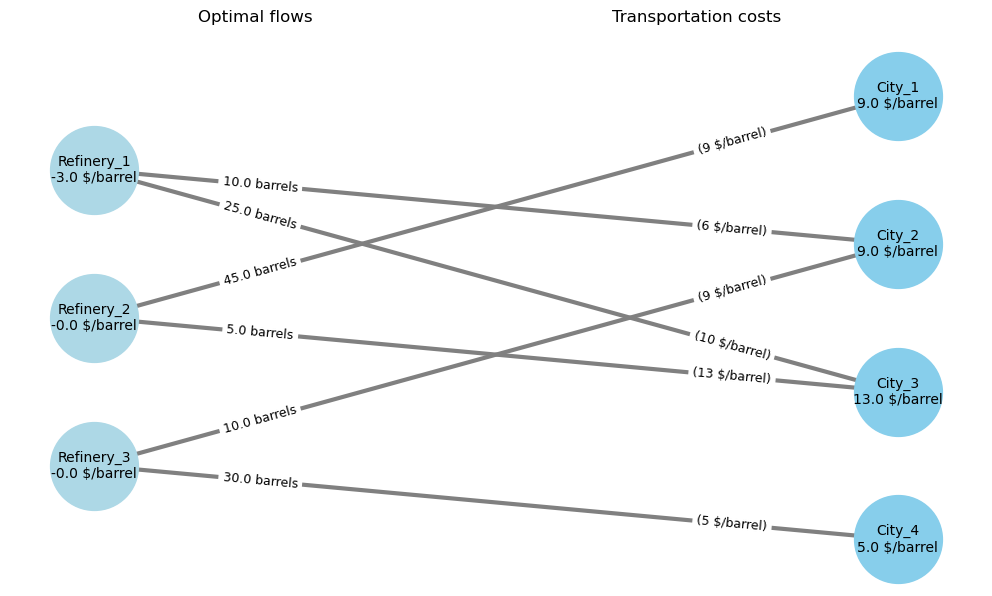

In [8]:
plot_tp_result(tp_model, refinery_duals, city_duals)


### Task 2: Analysing the relationship between transportation costs and nodal prices



In this exercise, you will analyze the relationship between nodal prices (dual variables) and transportation unit costs in the transportation problem. Nodal prices represent the marginal value of relaxing supply or demand constraints: Supply duals represent the marginal cost of increasing supply capacity at a refinery and demand duals represent the marginal cost of meeting additional demand at a city.

Modify transportation cost parameters and observe how nodal prices change relative to transportation costs. How do nodal prices relate to transportation unit costs? Why?

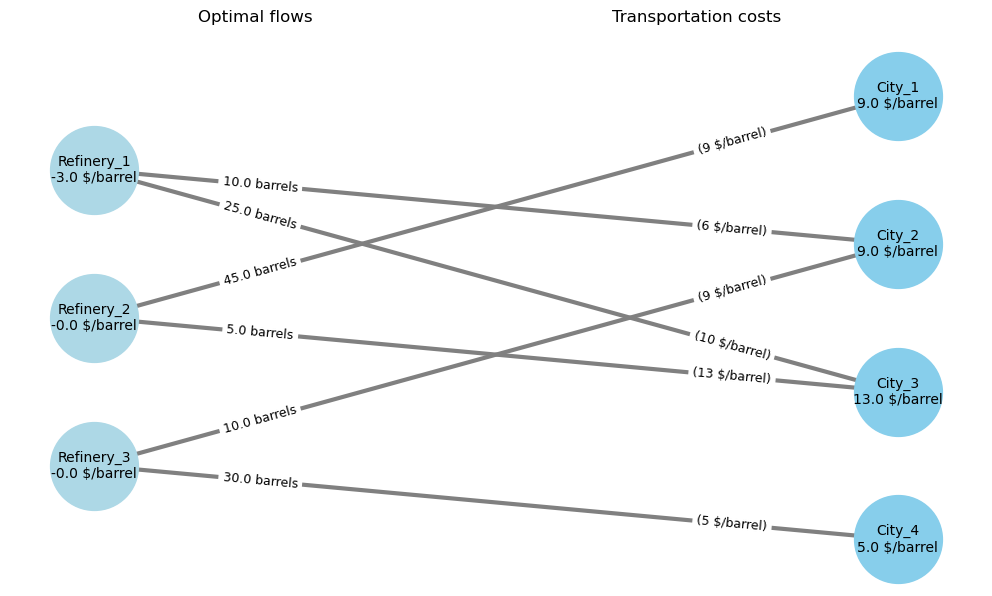

In [9]:
# Change these values to see how the results change
cost_data_new = {
    ('Refinery_1', 'City_1'): 8, ('Refinery_1', 'City_2'): 6, ('Refinery_1', 'City_3'): 10, ('Refinery_1', 'City_4'): 9,
    ('Refinery_2', 'City_1'): 9, ('Refinery_2', 'City_2'): 12, ('Refinery_2', 'City_3'): 13, ('Refinery_2', 'City_4'): 7,
    ('Refinery_3', 'City_1'): 14, ('Refinery_3', 'City_2'): 9, ('Refinery_3', 'City_3'): 16, ('Refinery_3', 'City_4'): 5
}


# Construct and solve new model
new_tp_model = construct_transportation_model(refineries, cities, supply_capacities, demand_quantities, cost_data_new)
solver.solve(new_tp_model, tee=False)

# Fetch optimal dual variable values
new_supply_duals = supply_duals(new_tp_model)
new_demand_duals = demand_duals(new_tp_model)

# Plot the result
plot_tp_result(new_tp_model, new_supply_duals, new_demand_duals)

# Exercise 1.2 : Portfolio Optimization

#### Problem Description

In the classic **Markowitz Mean-Variance Optimization** problem, the objective is to construct an investment portfolio using 3 stocks. The goal is to minimize portfolio risk (variance) while achieving a minimum expected return. 

#### Problem Data:
- **Assets**: 3 stocks with different expected returns
- **Risk**: Measured by portfolio variance using variance-covariance matrix
- **Objective**: Minimize portfolio variance for given return levels

#### Mathematical Formulation:

\begin{align*}
\min & \sum_{i \in I} \sum_{j \in J} v_{ij} x_i x_j = x^T V x \\
\text{s.t.} \quad & \sum_{i \in I} x_i = 1  && \text{Budget constraint: weights sum to 100\% } \\
& \sum_{i \in I} r_i x_i \geq \textit{$\rho$} \qquad  && \text{Return constraint: achieve minimum required return } \\
& x_{i} \geq 0, \qquad \forall i \in I \qquad &&  \text{Non-negativity: no short selling}
\end{align*}

where:
- $x_i$ are decision variables representing weight of stock $i$ in the portfolio
- The following are data:
    - $V$ is the variance-covariance matrix
    - $v_{ij}$ is the covariance between stocks $i$ and $j$
    - $r_i$ is the expected return of stock $i$
    - $\rho$ is the minimum required return
    - $I$ is the set of stocks

Notice that this is a **quadratic programming (QP)** problem due to the quadratic objective function. We will use **IPOPT** (Interior Point OPTimizer), which is suitable for nonlinear programming problems.

#### Define Problem Data

In [10]:
# Data from the table
returns = np.array([10, 20, 30])  # Expected returns for 3 assets
cov_matrix = np.array([
    [4.2,  -1.9,  2  ],
    [-1.9,  6.7, -5  ],
    [2,    -5,    7  ]
])

### Task 1: Implement the model

Function constructs the portfolio optimization model for a specified minimum return level, expected returns and covariance matrix.

In [11]:
def build_portfolio_model(minimum_return=15, returns=returns, cov_matrix=cov_matrix):
    
    # Initialize model
    model = ConcreteModel()
    
    # Sets and indices
    n_assets = len(returns)
    model.I = RangeSet(0, n_assets-1)  # 3 assets: 0, 1, 2
    
    # Variables
    model.x = Var(model.I, domain=NonNegativeReals, bounds=(0, 1))
    
    # Objective: Minimize variance
    def variance_rule(m):
        return sum(cov_matrix[i, j] * m.x[i] * m.x[j] 
                   for i in m.I for j in m.I)
    model.variance = Objective(rule=variance_rule, sense=minimize)
    
    # Constraint 1: Full investment
    model.budget = Constraint(expr=sum(model.x[i] for i in model.I) == 1)
    
    # Constraint 2: Minimum return requirement
    model.minimum_return = Constraint(
        expr=sum(returns[i] * model.x[i] for i in model.I) >= minimum_return
    )
    
    return model

### Task 2: Analysis and Extensions

1. **Risk Tolerance Analysis**: How does the optimal portfolio change as we increase the minimum expected return? What happens to the risk of the portfolio?

2. **New Asset**: Add a fourth stock with 25% expected return and moderate correlations with existing stocks and Covariance = [1.5]
                   [-1.2]
                   [2.0]
                   [6.0]
    How does the solution compare to the original 3-stock portfolio with a minimum return of 20%?

##### **Risk Tolerance Analysis**

We will investigate risk tolerance by generating the **efficient frontier** and observing how the portfolio composition and the expected return changes as we increase the minimum expected return.

In [12]:
# Generate Efficient Frontier with custom target returns
minimum_returns = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 29, 29.5, 29.7, 29.9]
frontier_results = []

# Define solver
solver = SolverFactory('ipopt')

# Iterate over target returns and solve
for min_return in minimum_returns:
    # Construct model and solve it
    model = build_portfolio_model(minimum_return = min_return)
    result = solver.solve(model, tee=False)
    
    # Check if the solution is optimal
    if result.solver.termination_condition == TerminationCondition.optimal:

        # Fetch optimal portfolio weights
        weights = [value(model.x[i]) for i in model.I]
        
        # Fetch objective value
        variance = value(model.variance)

        # Calculate expected return
        expected_return = sum(returns[i] * weights[i] for i in range(3))
        
        frontier_results.append({
            'Minimum Return': min_return,
            'Expected Return': round(expected_return, 2),
            'Variance': round(variance, 4),
            '   x1': round(weights[0], 2),
            '   x2': round(weights[1], 2),
            '   x3': round(weights[2],2)
        })

# Create DataFrame
df = pd.DataFrame(frontier_results)
print("\n" + "="*80)
print("EFFICIENT FRONTIER RESULTS")
print("="*80)
print(df.to_string(index=False))
print("="*80)


EFFICIENT FRONTIER RESULTS
 Minimum Return  Expected Return  Variance     x1     x2     x3
            0.0            21.57    0.7418   0.20   0.44   0.36
            2.0            21.57    0.7418   0.20   0.44   0.36
            4.0            21.57    0.7418   0.20   0.44   0.36
            6.0            21.57    0.7418   0.20   0.44   0.36
            8.0            21.57    0.7418   0.20   0.44   0.36
           10.0            21.57    0.7418   0.20   0.44   0.36
           12.0            21.57    0.7418   0.20   0.44   0.36
           14.0            21.57    0.7418   0.20   0.44   0.36
           16.0            21.57    0.7418   0.20   0.44   0.36
           18.0            21.57    0.7418   0.20   0.44   0.36
           20.0            21.57    0.7418   0.20   0.44   0.36
           22.0            22.00    0.7445   0.18   0.44   0.38
           24.0            24.00    0.8306   0.07   0.47   0.47
           26.0            26.00    1.1920  -0.00   0.40   0.60
           2

Below we visualise the efficient frontier showing the relationship between risk (variance) and return for different portfolio compositions.

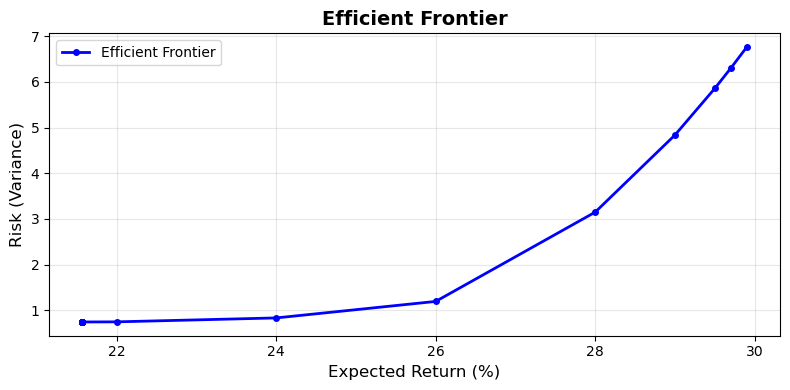

PORTFOLIO EXAMPLES
 Minimum Return  Expected Return  Variance     x1     x2     x3
            0.0            21.57    0.7418    0.2   0.44   0.36
            8.0            21.57    0.7418    0.2   0.44   0.36
           18.0            21.57    0.7418    0.2   0.44   0.36
           28.0            28.00    3.1480   -0.0   0.20   0.80
           29.9            29.90    6.7624   -0.0   0.01   0.99


In [13]:
# Initialize plot
plt.figure(figsize=(8, 4))

# Plot returns against variance (efficient frontier)
plt.plot(df['Expected Return'], df['Variance'], 'b-o', 
         linewidth=2, markersize=4, label='Efficient Frontier')

# Define labels and plot parameters
plt.title('Efficient Frontier', fontsize=14, fontweight='bold')
plt.ylabel('Risk (Variance)', fontsize=12)
plt.xlabel('Expected Return (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print some portfolio examples
print("="*80)
print("PORTFOLIO EXAMPLES")
print("="*80)
examples = df.iloc[[0, len(df)//4, len(df)//2, 3*len(df)//4, -1]]
print(examples.to_string(index=False))
print("="*80)

##### **Adding a new asset**

Add a fourth stock with 25% expected return and moderate correlations with existing stocks. Use covariance values $v_{14}=v_{41}=1.5$, $v_{24} = v_{42}=−1.2$, $v_{34} = v_{43}=2$, $v_{44}=6$.

How does the solution of the 4-stock portfolio compare to the original 3-stock portfolio when the minimum return requirement is 20%?



In [14]:
# Fill in the 0.0 values with appropriate values to add a fourth asset
returns_new = np.array([10, 20, 30, 25])
                        
cov_matrix_new = np.array([
    [ 4.2,   -1.9,   2,   1.5],
    [-1.9,   6.7,   -5,  -1.2],
    [   2,    -5,    7,     2],
    [ 1.5,  -1.2,    2,     6]
])

# Set minimum return to 20%
min_return = 20

# Construct and solve new model with minimum return of 20%
new_model = build_portfolio_model(minimum_return=min_return, returns=returns_new, cov_matrix=cov_matrix_new)
solver.solve(new_model, tee=False)

# Fetch optimal results
weights = [value(new_model.x[i]) for i in new_model.I]
variance = value(new_model.variance)
actual_return = sum(returns_new[i] * weights[i] for i in new_model.I)

# Print results
print("\n=== Single Run Results ===")
print(f"Minimum Return: {min_return}")
print(f"Actual Return: {actual_return:.4f}")
print(f"Risk (Variance): {variance:.4f}")
for i in new_model.I:
    print(f"Weight Asset {i+1}: {weights[i]:.4f}")


=== Single Run Results ===
Minimum Return: 20
Actual Return: 21.7724
Risk (Variance): 0.7306
Weight Asset 1: 0.1872
Weight Asset 2: 0.4252
Weight Asset 3: 0.3414
Weight Asset 4: 0.0462


Compare the 4-stock portfolio solution to the original 3-stock portfolio with a minimum return of 20%. The cell below runs the 3-stock portfolio optimization problem and displays the results.

In [15]:
# Set minimum return to 20% for original 3-asset model
min_return = 20

# Solve the original problem
original_model = build_portfolio_model(minimum_return=min_return)
solver.solve(original_model, tee=False)

# Fetch optimal results
weights = [value(original_model.x[i]) for i in original_model.I]
variance = value(original_model.variance)
actual_return = sum(returns_new[i] * weights[i] for i in original_model.I)

# Print results
print("\n=== Single Run Results ===")
print(f"Minimum Return: {min_return}")
print(f"Actual Return: {actual_return:.4f}")
print(f"Risk (Variance): {variance:.4f}")
for i in original_model.I:
    print(f"Weight Asset {i+1}: {weights[i]:.4f}")


=== Single Run Results ===
Minimum Return: 20
Actual Return: 21.5738
Risk (Variance): 0.7418
Weight Asset 1: 0.2028
Weight Asset 2: 0.4370
Weight Asset 3: 0.3602


# Exercise 1.3 : Analyzing Convexity of Functions

Explore the convexity of the following five functions by plotting them in 3D and as level curves:  
1. $f(x) = x^{2}$
2. $f(x) = -x^{2}$
3. $f(x) = 3x + 7 + \sin(1)$
4. $f(x,y) = xy$
5. $f(x,y) = x^{2} + y^{2}$
6. Rosenbrock function

Discuss how these visualizations reveal convexity properties.

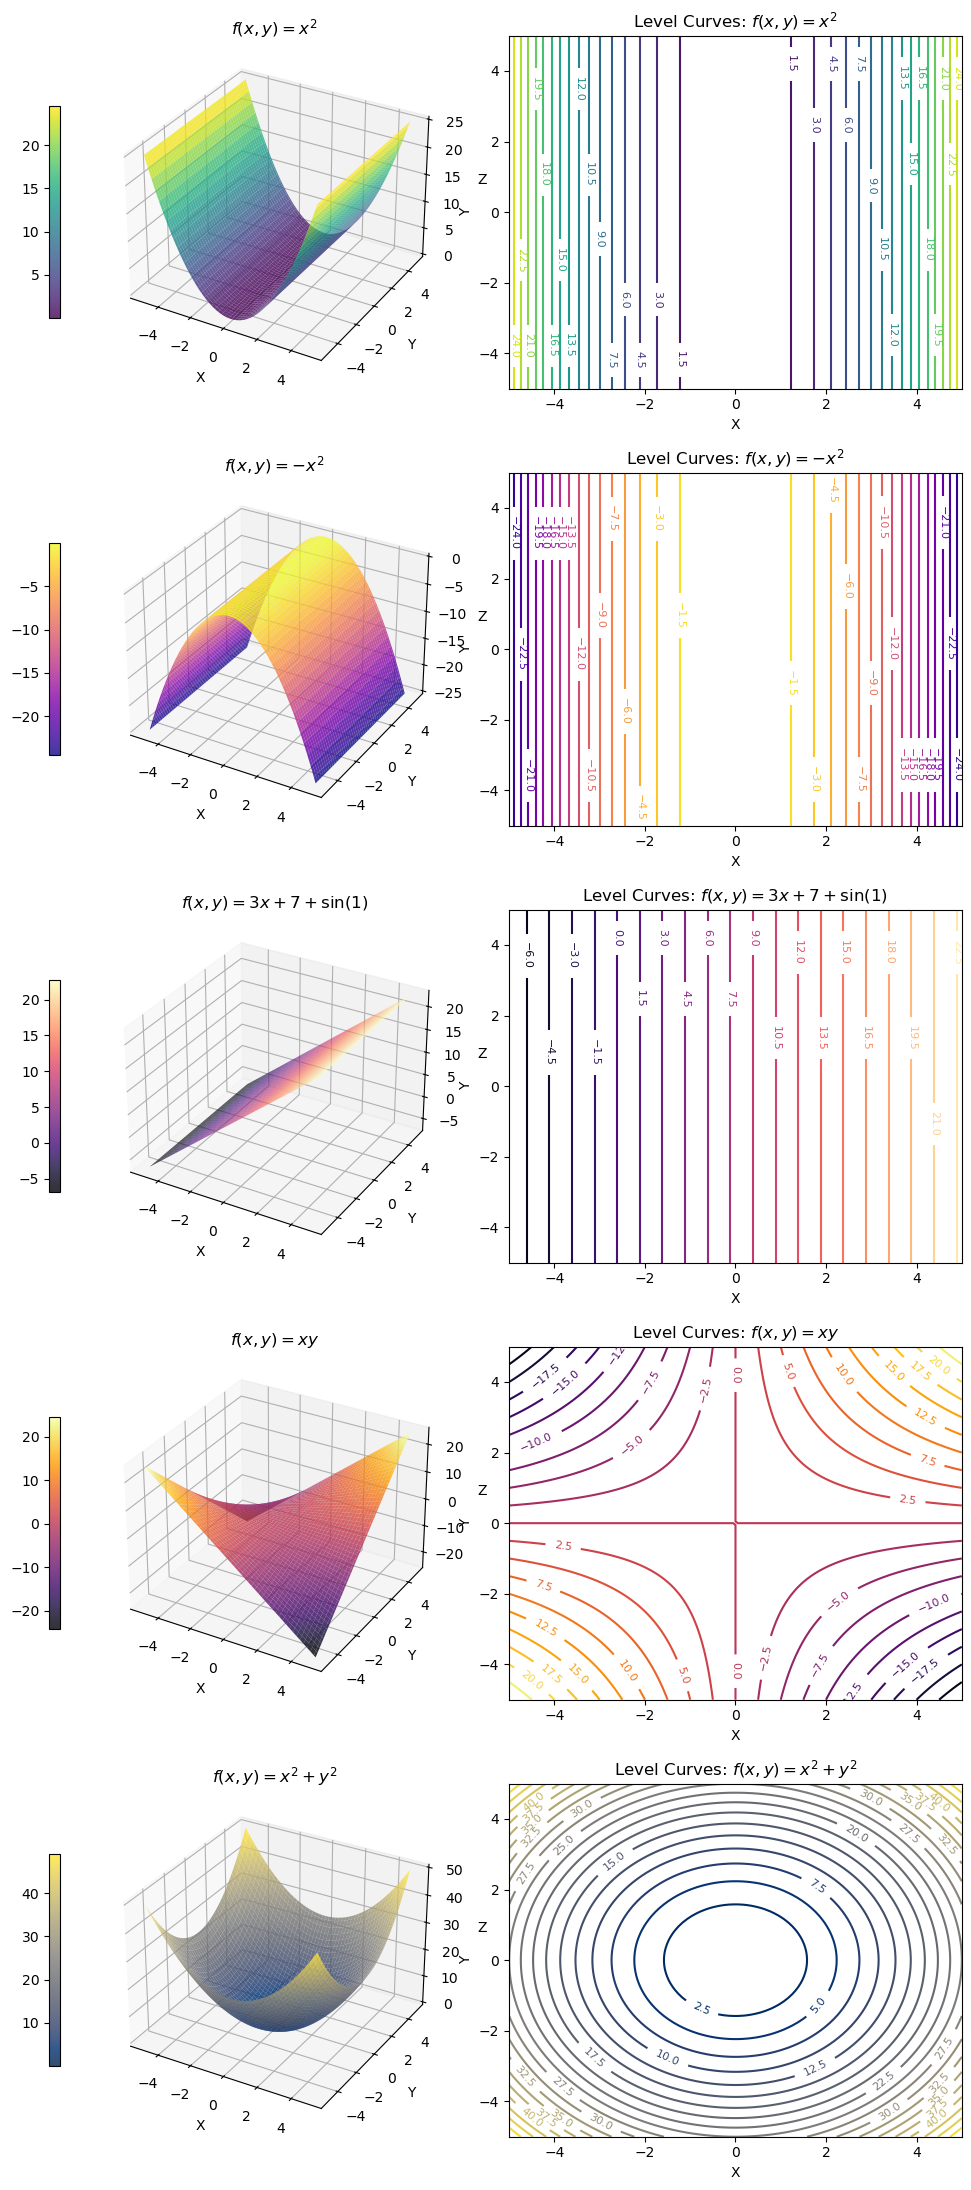

In [16]:
# Define grid for plotting
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Define the five functions
Z1 = X**2
Z2 = -X**2
Z3 = 3 * X + 7 + np.sin(1)
Z4 = X * Y
Z5 = X**2 + Y**2

Z_list = [
    (Z1, r"$f(x, y) = x^2$", r"Level Curves: $f(x, y) = x^2$", 'viridis'),
    (Z2, r"$f(x, y) = -x^2$", r"Level Curves: $f(x, y) = -x^2$", 'plasma'),
    (Z3, r"$f(x, y) = 3x + 7 + \sin(1)$", r"Level Curves: $f(x, y) = 3x + 7 + \sin(1)$", 'magma'),
    (Z4, r"$f(x, y) = x y$", r"Level Curves: $f(x, y) = x y$", 'inferno'),
    (Z5, r"$f(x, y) = x^2 + y^2$", r"Level Curves: $f(x, y) = x^2 + y^2$", 'cividis')
]

fig = plt.figure(figsize=(10, 22))

for i, (Z, surf_title, cont_title, cmap) in enumerate(Z_list):
    # Left column: 3D surface
    ax_surf = fig.add_subplot(5, 2, 2*i+1, projection='3d')
    surf = ax_surf.plot_surface(X, Y, Z, cmap=cmap, alpha=0.8)
    ax_surf.set_title(surf_title)
    ax_surf.set_xlabel('X')
    ax_surf.set_ylabel('Y')
    ax_surf.set_zlabel('Z')
    fig.colorbar(surf, ax=ax_surf, shrink=0.6, location='left')
    
    # Right column: contour plot
    ax_contour = fig.add_subplot(5, 2, 2*i+2)
    contour = ax_contour.contour(X, Y, Z, levels=20, cmap=cmap)
    ax_contour.clabel(contour, inline=True, fontsize=8)
    ax_contour.set_title(cont_title)
    ax_contour.set_xlabel('X')
    ax_contour.set_ylabel('Y')

plt.tight_layout()
plt.show()

**Rosenbrock function:**

 $f(x, y) = 100(y - x^2)^2 + (1 - x)^2$ 
 
 is a classic non-convex function with a narrow, curved valley leading to the global minimum at (1,1). It is often used to test optimization algorithms due to its challenging landscape.

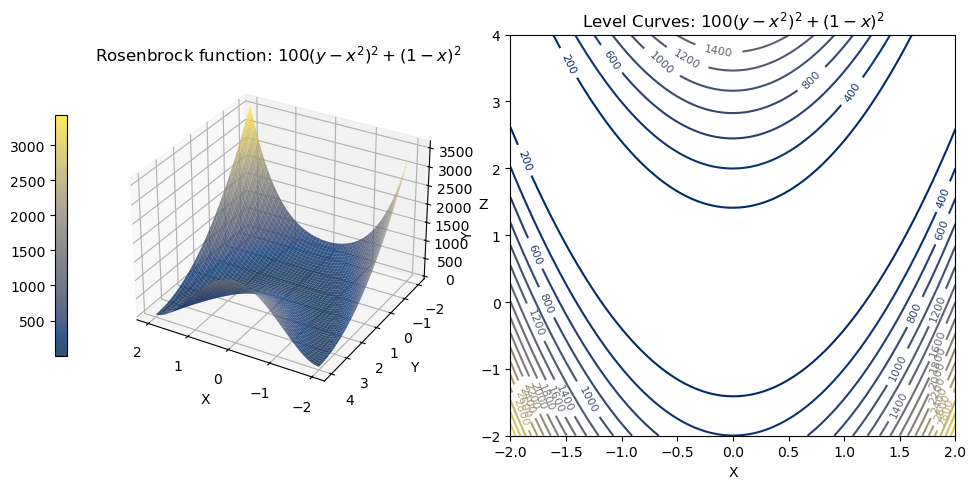

In [17]:
# Define grid for plotting
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 4, 100)
X, Y = np.meshgrid(x, y)

# Define the five functions
Z = 100* (Y-X**2)**2 + (1 - X)**2

fig = plt.figure(figsize=(10, 5))


# Left column: 3D surface
ax_surf = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax_surf.plot_surface(X, Y, Z, cmap=cmap, alpha=0.8)
ax_surf.view_init(azim=120)
ax_surf.set_title('Rosenbrock function: $100(y - x^2)^2 + (1 - x)^2$')
ax_surf.set_xlabel('X')
ax_surf.set_ylabel('Y')
ax_surf.set_zlabel('Z')
fig.colorbar(surf, ax=ax_surf, shrink=0.6, location='left')

# Right column: contour plot
ax_contour = fig.add_subplot(1, 2, 2)
contour = ax_contour.contour(X, Y, Z, levels=20, cmap=cmap)
ax_contour.clabel(contour, inline=True, fontsize=8)
ax_contour.set_title('Level Curves: $100(y - x^2)^2 + (1 - x)^2$')
ax_contour.set_xlabel('X')
ax_contour.set_ylabel('Y')

plt.tight_layout()
plt.show()